# Model Evaluation

Evaluate all wind speed prediction models using the evaluation framework.


In [11]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from eval_helpers import evaluate, plot_predictions, compare, compute_metrics
from data.data_helpers import get_dataframe
from models import (
    PersistenceModel,
    LinearRegressionModel,
    RandomForestModel,
    XGBoostModel,
    MLPModel,
)
from transform_pipeline import AsymmetricPostHocRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load Data


In [12]:
# Load data
df = get_dataframe()
df = df.dropna(subset=["target_next_hour"])

# Temporal split: 2018-2019 for training, 2020 for testing
train_df = df[df["datetime"] < "2020-01-01"].copy()
test_df = df[df["datetime"] >= "2020-01-01"].copy()

print(f"Training set: {len(train_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

# Store datetime for plotting
test_datetime = test_df["datetime"].copy()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-12-06 18:37:42,847 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2018_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2018_H2.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2019_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2019_H2.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2020_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2020_H2.nc
Training set: 17,520 samples
Test set: 8,783 samples


## Evaluate Models

Evaluate each model and collect results.



Training PersistenceBaseline model...


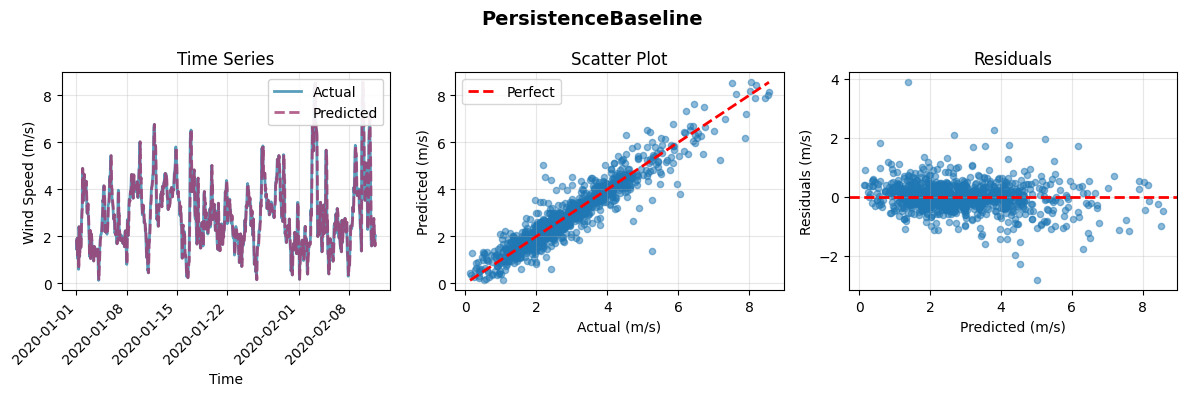


Training LinearRegression model...


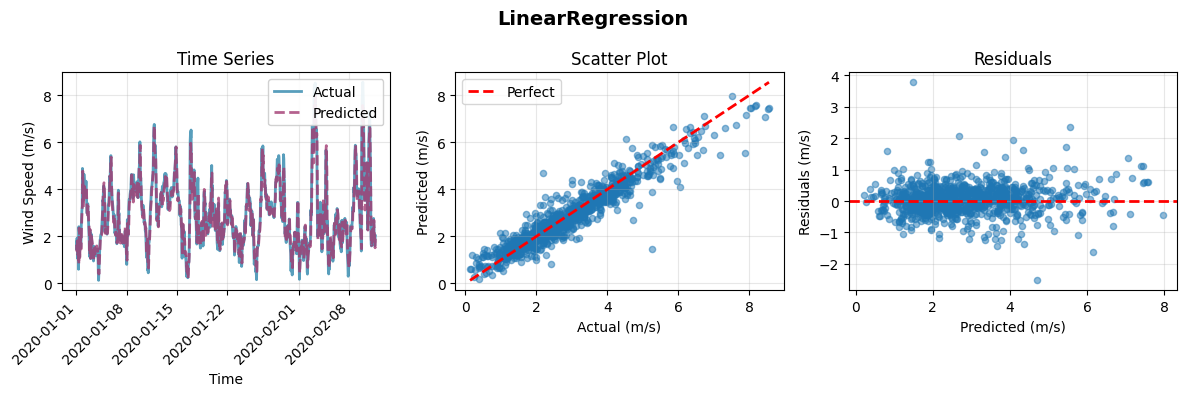


Training RandomForest model...


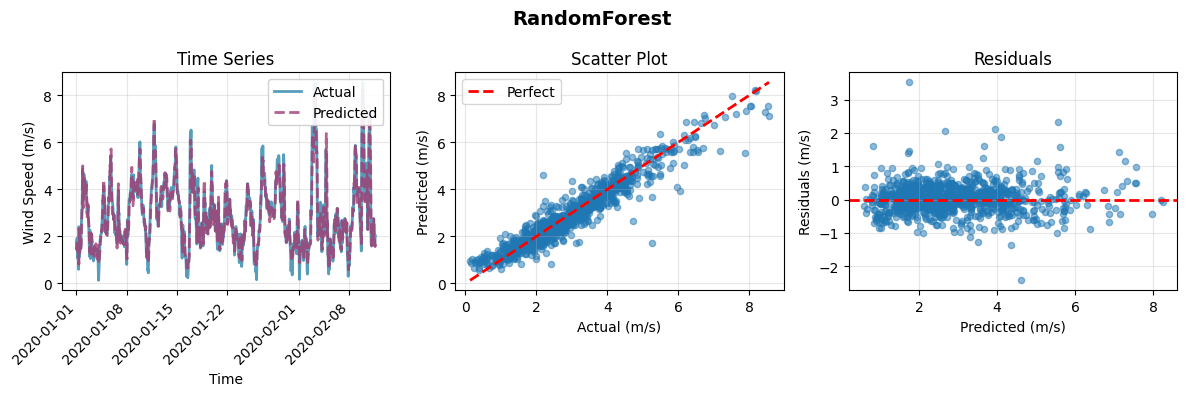


Training XGBoost model...


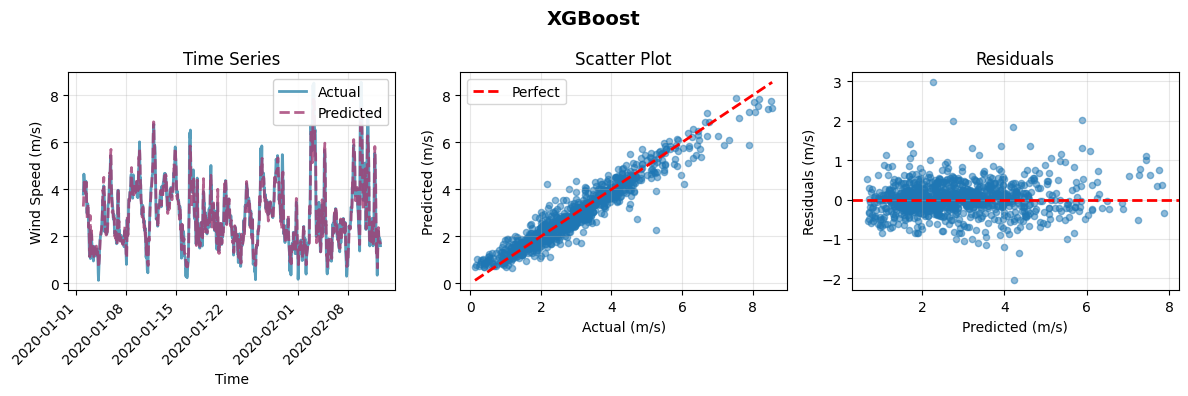

In [13]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [
    {'name': 'PersistenceBaseline', 'constructor': PersistenceModel, 'data_view': 'full'},
    {'name': 'LinearRegression', 'constructor': LinearRegressionModel, 'data_view': 'features'},
    {'name': 'RandomForest', 'constructor': RandomForestModel, 'data_view': 'features'},
    {'name': 'XGBoost', 'constructor': XGBoostModel, 'data_view': 'full', 'mask_nan_predictions': True},
    # {'name': 'MLP', 'constructor': MLPModel, 'data_view': 'features'},
]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()


## Compare All Models



MODEL COMPARISON
              Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
            XGBoost   0.234200    0.334254 0.942896        0.169998
       RandomForest   0.251329    0.360330 0.933627        0.201054
   LinearRegression   0.280173    0.392446 0.921268        0.236544
PersistenceBaseline   0.315406    0.452842 0.895170        0.308777


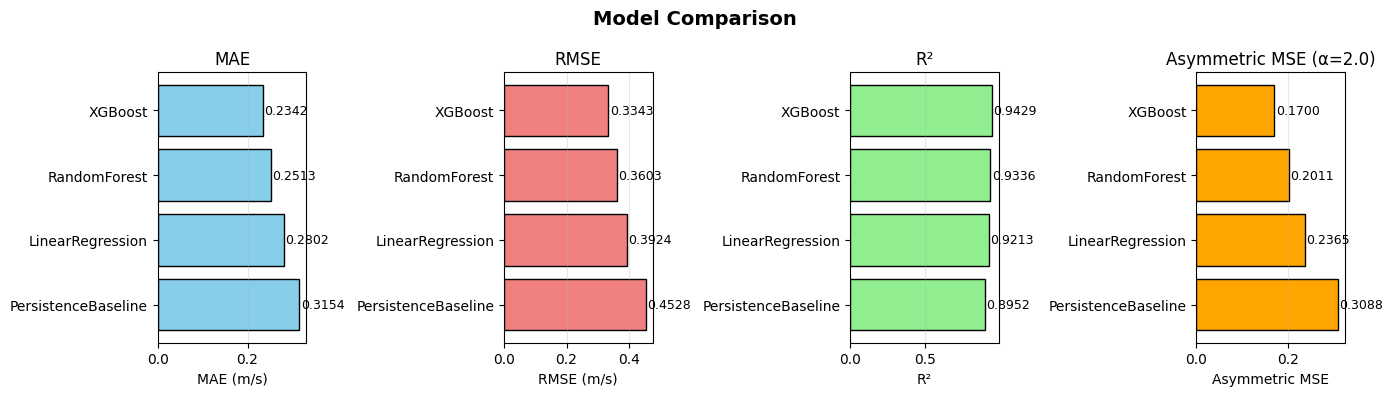

In [14]:
# Compare all models
scorecard = compare(results, plot=True)


## Post-Hoc Calibration (Output Adjustment)

Apply post-hoc calibration to standard models to improve asymmetric loss performance. 
We exclude MLP since it already uses the custom loss during training.

In [15]:
# Reuse existing data splits, but create validation set from training data
# Split training data: 80% for model training, 20% for post-hoc calibration
split_idx = int(len(train_df) * 0.8)
X_train_cal = train_df.iloc[:split_idx].copy()
X_val_cal = train_df.iloc[split_idx:].copy()
y_train_cal = train_df['target_next_hour'].iloc[:split_idx].copy()
y_val_cal = train_df['target_next_hour'].iloc[split_idx:].copy()

print(f"Calibration train size: {len(X_train_cal):,}")
print(f"Calibration val size: {len(X_val_cal):,}")
print(f"Test size: {len(test_df):,}")


Calibration train size: 14,016
Calibration val size: 3,504
Test size: 8,783


In [16]:
# Create calibrated versions of standard models (excluding MLP which already uses custom loss)
# Use consistent naming with eval.ipynb
models_to_calibrate = {
    'PersistenceBaseline': PersistenceModel,
    'LinearRegression': LinearRegressionModel,
    'RandomForest': RandomForestModel,
    'XGBoost': XGBoostModel,
}

# Store calibrated models
calibrated_models = {}
alpha_cal = 2.0  # Same alpha as used in MLP training


In [17]:
for model_name, model_class in models_to_calibrate.items():
    print(f"\n=== Calibrating {model_name} ===")
    
    # Train base model on calibration training set
    base_model = model_class()
    
    # Use appropriate data view based on model requirements
    if model_name == 'PersistenceBaseline' or model_name == 'XGBoost':
        X_train_sel = X_train_cal
        X_val_sel = X_val_cal
        y_train_sel = y_train_cal
        y_val_sel = y_val_cal
    else:
        DROP_COLS = ['datetime', 'target_next_hour']
        X_train_sel = X_train_cal.drop(columns=DROP_COLS)
        X_val_sel = X_val_cal.drop(columns=DROP_COLS)
        y_train_sel = y_train_cal
        y_val_sel = y_val_cal
    
    base_model.fit(X_train_sel, y_train_sel)
    
    # Create and fit post-hoc calibrator
    calibrator = AsymmetricPostHocRegressor(
        base_model=base_model,
        alpha=alpha_cal,
        lr=1e-2,
        n_steps=500,
        verbose=True,
        min_improvement=0.0,
    )
    calibrator.fit(X_val_sel, y_val_sel)
    
    calibrated_models[model_name] = calibrator
    print(f"Transform used: {calibrator.use_transform_}")
    if calibrator.use_transform_:
        print(f"  a={calibrator.a_:.4f}, b={calibrator.b_:.4f}")


=== Calibrating PersistenceBaseline ===
[AsymmetricPostHocRegressor] step=  0 loss=0.290316 a=1.0100 b=0.0100
[AsymmetricPostHocRegressor] step=100 loss=0.268942 a=0.9554 b=0.2297
[AsymmetricPostHocRegressor] step=200 loss=0.268942 a=0.9551 b=0.2309
[AsymmetricPostHocRegressor] step=300 loss=0.268942 a=0.9551 b=0.2308
[AsymmetricPostHocRegressor] step=400 loss=0.268942 a=0.9551 b=0.2308
[AsymmetricPostHocRegressor] base_loss=0.290316, posthoc_loss=0.268942
Using post-hoc transform: a=0.9551, b=0.2308
Transform used: True
  a=0.9551, b=0.2308

=== Calibrating LinearRegression ===
[AsymmetricPostHocRegressor] step=  0 loss=0.227132 a=1.0100 b=0.0100
[AsymmetricPostHocRegressor] step=100 loss=0.216428 a=1.0026 b=0.0796
[AsymmetricPostHocRegressor] step=200 loss=0.216428 a=1.0025 b=0.0800
[AsymmetricPostHocRegressor] step=300 loss=0.216428 a=1.0025 b=0.0800
[AsymmetricPostHocRegressor] step=400 loss=0.216428 a=1.0025 b=0.0800
[AsymmetricPostHocRegressor] base_loss=0.227132, posthoc_loss=0

## Evaluate Calibrated Models

Re-evaluate all calibrated models using the same evaluation framework.



Evaluating calibrated PersistenceBaseline...


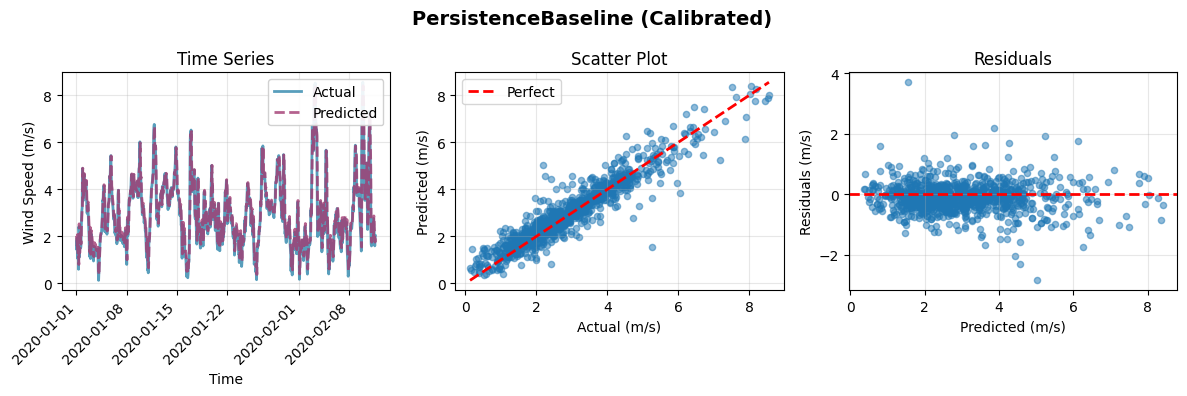


Evaluating calibrated LinearRegression...


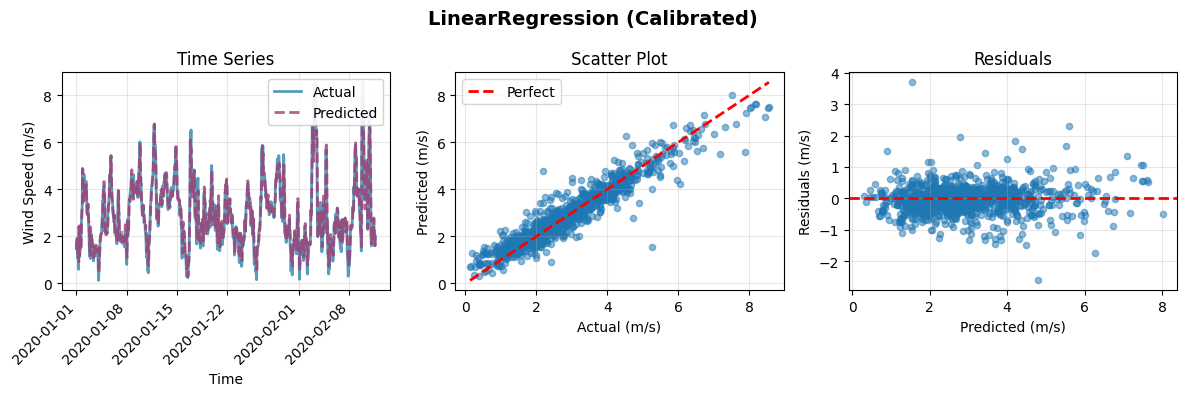


Evaluating calibrated RandomForest...


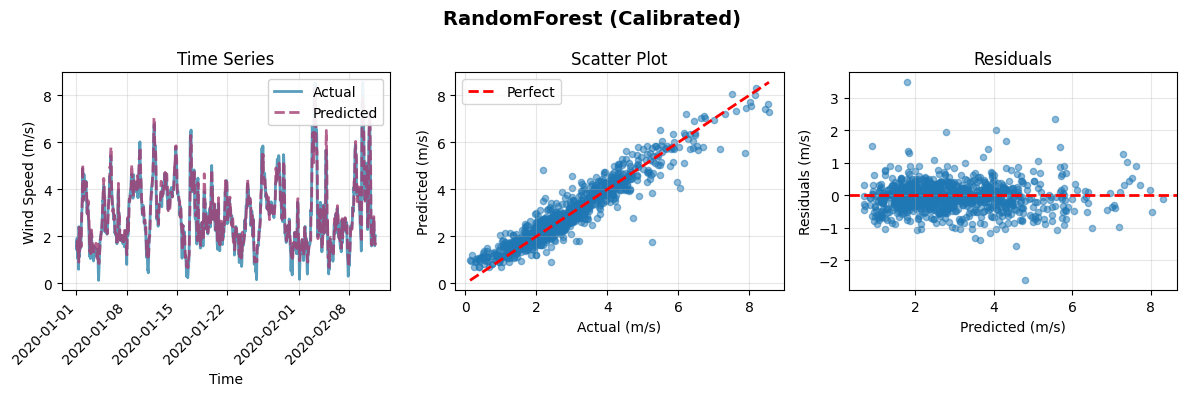


Evaluating calibrated XGBoost...


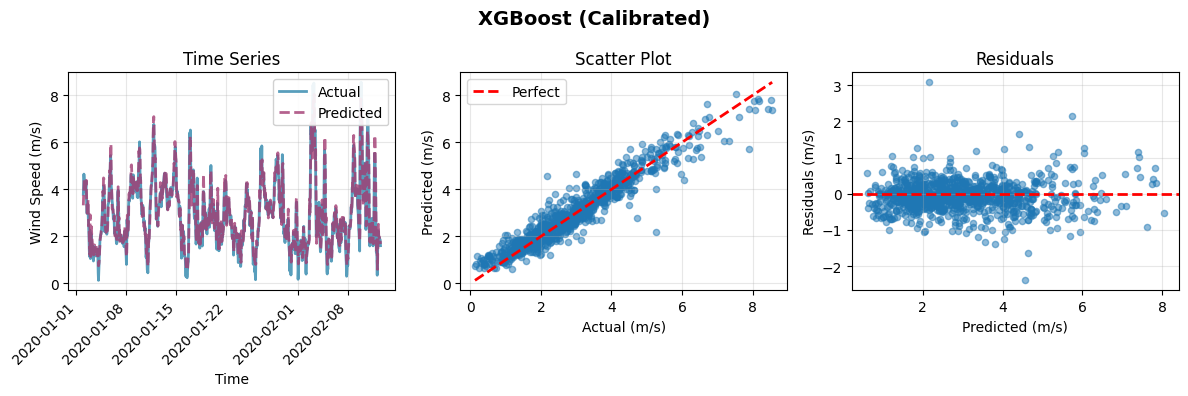

In [18]:
# Evaluate calibrated models on test set
# Note: Models are already trained, so we create predictions directly and use compute_metrics
calibrated_results = []

for model_name, calibrated_model in calibrated_models.items():
    print(f"\nEvaluating calibrated {model_name}...")
    
    # Get appropriate test data view
    if model_name == 'PersistenceBaseline' or model_name == 'XGBoost':
        X_test_sel = test_df
    else:
        DROP_COLS = ['datetime', 'target_next_hour']
        X_test_sel = test_df.drop(columns=DROP_COLS)
    
    # Make predictions (model is already trained)
    y_pred = calibrated_model.predict(X_test_sel)
    
    # Handle NaN predictions
    y_pred = np.array(y_pred).flatten()
    valid_mask = ~np.isnan(y_pred)
    
    if valid_mask.sum() == 0:
        print(f"Warning: All predictions are NaN for {model_name}")
        continue
    
    # Compute metrics
    y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test).flatten()
    metrics = compute_metrics(y_test_array[valid_mask], y_pred[valid_mask], alpha=alpha_cal)
    
    calibrated_results.append({
        'model_name': f'{model_name} (Calibrated)',
        'metrics': metrics,
        'predictions': y_pred
    })
    
    # Plot predictions
    if model_name == 'XGBoost':
        # XGBoost may have NaN predictions that need special handling
        valid_mask_plot = ~np.isnan(y_pred)
        if valid_mask_plot.sum() > 0:
            preds_plot = y_pred[valid_mask_plot]
            y_plot = y_test.iloc[valid_mask_plot] if hasattr(y_test, 'iloc') else y_test[valid_mask_plot]
            datetime_plot = test_datetime.iloc[valid_mask_plot] if hasattr(test_datetime, 'iloc') else test_datetime[valid_mask_plot]
        else:
            print(f"Skipping plot for {model_name} (all predictions NaN).")
            continue
    else:
        preds_plot = y_pred[valid_mask]
        y_plot = y_test.iloc[valid_mask] if hasattr(y_test, 'iloc') else y_test[valid_mask]
        datetime_plot = test_datetime.iloc[valid_mask] if hasattr(test_datetime, 'iloc') else test_datetime[valid_mask]
    
    plot_predictions(y_plot, preds_plot, model_name=f'{model_name} (Calibrated)', datetime_index=datetime_plot)
    plt.show()


## Compare All Models (Original + Calibrated)

Compare original models with their calibrated versions using the same evaluation framework.


Note: MLP not found in results (may be commented out). Showing only calibrated models.

COMPARISON: Calibrated Models Only

MODEL COMPARISON (Calibrated Models)
              Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
            XGBoost   0.251069    0.351339 0.936909        0.163370
       RandomForest   0.266644    0.375220 0.928028        0.192855
   LinearRegression   0.289361    0.400729 0.917909        0.221065
PersistenceBaseline   0.330884    0.457312 0.893090        0.286248


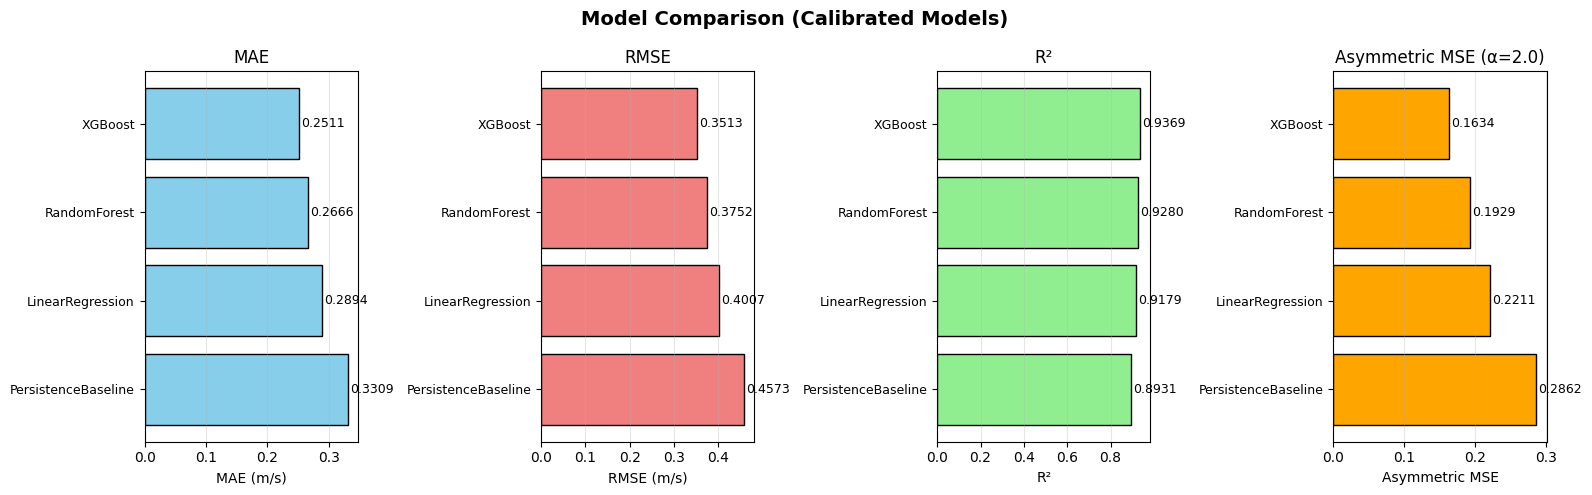


MODEL COMPARISON
              Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
            XGBoost   0.234200    0.334254 0.942896        0.169998
       RandomForest   0.251329    0.360330 0.933627        0.201054
   LinearRegression   0.280173    0.392446 0.921268        0.236544
PersistenceBaseline   0.315406    0.452842 0.895170        0.308777


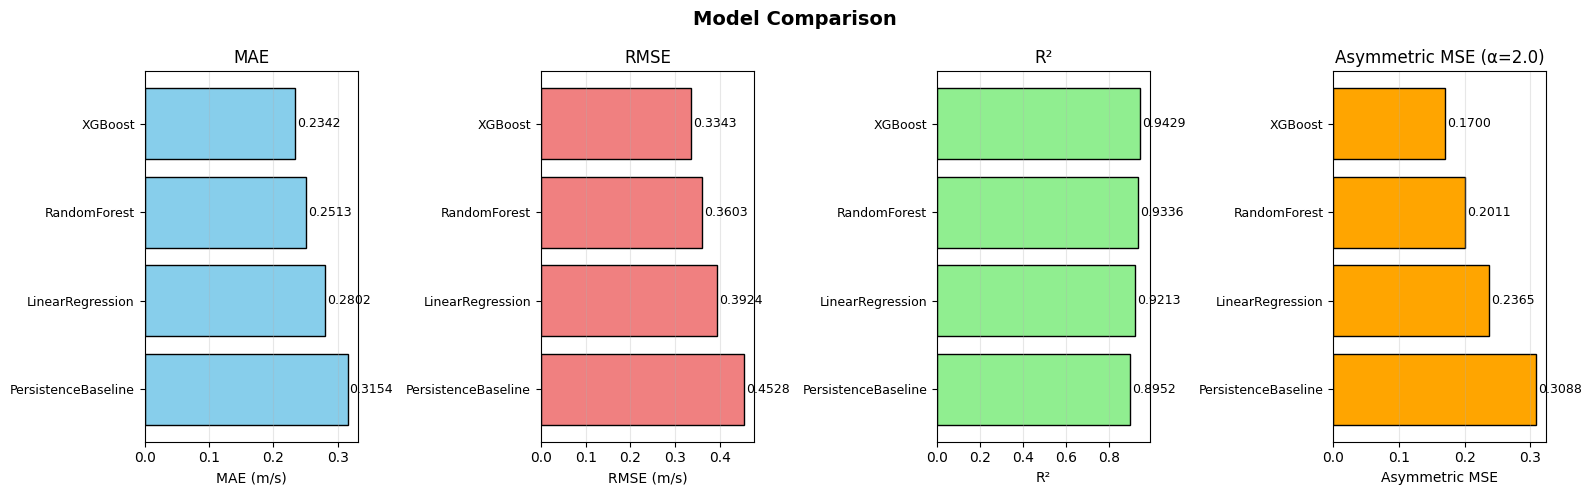

In [22]:
# Combine MLP (from original results) with calibrated models
# We only want calibrated models + MLP (which already uses custom loss)
mlp_results = [r for r in results if r['model_name'] == 'MLP']

if len(mlp_results) == 0:
    print("Note: MLP not found in results (may be commented out). Showing only calibrated models.")
    all_results = calibrated_results
    comparison_title = "COMPARISON: Calibrated Models Only"
else:
    all_results = mlp_results + calibrated_results
    comparison_title = "COMPARISON: Calibrated Models + MLP (Custom Loss)"

# Compare calibrated models + MLP (if available)
# Reload eval_helpers to get the latest version with title_suffix parameter
import importlib
import eval_helpers
importlib.reload(eval_helpers)
from eval_helpers import compare

# Determine title suffix based on whether we have calibrated models
if len(calibrated_results) > 0:
    title_suffix = " (Calibrated Models)"
else:
    title_suffix = ""

print("\n" + "="*80)
print(comparison_title)
print("="*80)
scorecard_all = compare(all_results, plot=True, title_suffix=title_suffix)

# for reference, the uncalibrated models
scorecard = compare(results, plot=True)
